# Backpropagation

## Backwardをスクラッチで実装

In [90]:
import torch
import numpy as np
from torch.nn import functional as F
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [91]:
def linear_backward(A, W, b, Z):
    W.grad_ = Z.grad_.T @ A
    b.grad_ = torch.sum(Z.grad_, dim = 0)
    A.grad_ = Z.grad_ @ W

def relu_backward(Z, A):
    Z.grad_ = A.grad_ * (Z > 0).float()

In [18]:
def softmax_cross_entropy(x, y_true):
    e_x = torch.exp(x - torch.max(x, dim = 1, keepdim = True)[0])
    softmax_out = e_x / (torch.sum(e_x, dim = 1, keepdim = True) + 1e-10)
    loss = - torch.sum(y_true * torch.log(softmax_out + 1e-10)) / softmax_out.shape[0]
    return loss, softmax_out

In [71]:
def relu(Z):
    return Z.clamp_min(0.)

def linear(X, W, b):
    return X @ W.T + b

def forward_and_backward(X, y):
    # forward
    Z1 = linear(X, W1, b1)
    # Z1.retain_grad()
    A1 = relu(Z1)
    # A1.retain_grad()
    Z2 = linear(A1, W2, b2)
    # Z2.retain_grad()
    loss, A2 = softmax_cross_entropy(Z2, y)

    # backward
    Z2.grad_ = (A2 - y) / X.shape[0]
    linear_backward(A1, W2, b2, Z2)
    relu_backward(Z1, A1)
    linear_backward(X, W1, b1, Z1)
    return loss, Z1, A1, Z2, A2

## Autogradの結果と一致することを確認

In [98]:
# 1. データロード
dataset = datasets.load_digits()
images = dataset['images']
target = dataset['target']

In [99]:
# 学習データと検証データ分割
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1437, 8, 8) (1437,)
(360, 8, 8) (360,)


In [100]:
# 前処理
# 2-1.ラベルのone-hot encoing
y_train = F.one_hot(torch.tensor(y_train), num_classes=10)
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 64)

y_val = F.one_hot(torch.tensor(y_val), num_classes=10)
X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, 64)

# 2-2. 画像の標準化
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_train_mean) / X_train_std
# 以下のように手元のデータ全ての平均&標準偏差を使えば，学習データと検証データの分布を近くすることが可能
# しかし，この場合validationの精度は，未知のデータよりも若干高くなることに注意
# X_train = (X_train - images.mean()) / images.std()
# X_val = (X_val - images.mean()) / images.std()

In [14]:
# パラメータの初期化
nh = 30
m, n = X_train.shape
class_num = 10
W1 = torch.randn((nh, n), requires_grad = True)
b1 = torch.zeros((1, nh), requires_grad = True)
W2 = torch.randn((class_num, nh), requires_grad = True)
b2 = torch.zeros((1, class_num), requires_grad = True)

In [19]:
# forward
Z1 = linear(X_train, W1, b1)
A1 = relu(Z1)
Z2 = linear(A1, W2, b2)
loss, softmax_out = softmax_cross_entropy(Z2, y_train)

# backward
loss.backward()
print(f'W2 : {W2.grad}')
print(f'b2 : {b2.grad}')
print(f'W1 : {W1.grad}')
print(f'b1 : {b1.grad}')

W2 : tensor([[ 1.3143e-02,  1.1095e-01,  4.5824e-02,  3.9017e-02,  2.1677e-01,
          2.1051e-01,  2.0029e-01,  5.5688e-03,  4.1368e-02,  4.0444e-02,
          1.1161e-01,  2.5959e-01, -6.2764e-03,  1.0683e-02,  2.9299e-02,
          9.1153e-02,  1.1856e-02,  7.5364e-02,  1.1260e-02,  1.2083e-01,
          4.1484e-03,  5.7614e-01, -2.6559e-03,  3.7110e-02,  8.8376e-02,
          1.3256e-01,  2.3965e-02, -2.9610e-02,  1.6344e-01,  1.0113e-01],
        [-3.5813e-02, -6.6053e-02, -2.0150e-03, -1.7855e-02, -1.9278e-01,
         -2.5582e-02, -1.7957e-02, -4.8477e-03, -2.2143e-04, -3.9434e-02,
         -3.4049e-02, -2.4977e-01,  1.2974e-05,  2.9152e-04, -4.8854e-03,
         -1.0347e-01, -6.3627e-03, -4.5157e-02, -1.2366e-02, -1.0970e-01,
          2.0201e-05, -2.3648e-01, -7.2061e-05, -1.8631e-02, -3.3196e-02,
         -6.8120e-02, -3.9963e-03, -4.8885e-03, -4.0558e-02, -2.2681e-02],
        [ 1.6471e-01, -4.5845e-02, -8.2367e-02, -8.9978e-02,  1.2123e-01,
          2.4588e-03,  3.8668e-

In [13]:
X_train.shape

torch.Size([1437, 64])

In [38]:
loss, Z1, A1, Z2, A2 = forward_and_backward(X_train, y_train)

In [39]:
W1.grad_

tensor([[-0.0848, -0.0728,  0.1156,  ...,  0.1083, -0.0896, -0.0819],
        [-0.4386, -0.3695,  0.3464,  ...,  0.1165, -0.1986, -0.3621],
        [-0.0332, -0.0314, -0.0121,  ..., -0.0674, -0.0785, -0.0508],
        ...,
        [-0.0105, -0.0141, -0.0160,  ..., -0.0101,  0.0223, -0.0028],
        [-0.0465, -0.0466, -0.0036,  ...,  0.0797,  0.0044, -0.0391],
        [-0.2458, -0.2194,  0.1161,  ...,  0.0891, -0.2243, -0.2342]],
       grad_fn=<MmBackward0>)

In [40]:
# autograd
loss.backward()

In [41]:
W1.grad

tensor([[ 0.0740,  0.0765,  0.2919,  ..., -0.1206, -0.0484,  0.0788],
        [-0.3272, -0.3039,  0.2049,  ...,  0.2580,  0.0439, -0.2203],
        [ 0.0775,  0.0749, -0.0421,  ..., -0.1119, -0.0296,  0.0351],
        ...,
        [ 0.0347,  0.0322, -0.0196,  ...,  0.0858,  0.1178,  0.0559],
        [-0.1352, -0.1253,  0.0472,  ...,  0.1626, -0.0150, -0.1125],
        [ 0.1760,  0.1756,  0.0784,  ..., -0.4079, -0.0059,  0.1867]])

In [42]:
Z2.grad_

tensor([[ 1.8300e-35,  7.0304e-09,  2.3612e-05,  ...,  6.6583e-04,
          2.6101e-20,  4.0653e-18],
        [-6.9589e-04,  1.8616e-21,  1.6223e-20,  ...,  1.1983e-34,
          6.9589e-04,  2.8809e-18],
        [-6.9589e-04,  3.0313e-15,  3.1849e-10,  ...,  1.6491e-25,
          2.4628e-07,  2.9364e-10],
        ...,
        [ 6.9555e-04,  2.9199e-21, -6.9589e-04,  ...,  2.9016e-34,
          9.3428e-28,  3.4734e-07],
        [ 6.9573e-04,  6.2657e-17,  1.6456e-07,  ..., -6.9589e-04,
          2.5545e-31,  6.9249e-17],
        [ 8.0490e-16, -6.9589e-04,  2.1820e-17,  ...,  2.7690e-18,
          1.4147e-28,  1.3104e-08]], grad_fn=<DivBackward0>)

In [43]:
Z2.grad

tensor([[ 1.8300e-35,  7.0304e-09,  2.3612e-05,  ...,  6.6583e-04,
          2.6101e-20,  4.0653e-18],
        [-9.2388e-11,  2.4715e-28,  2.1537e-27,  ...,  1.5909e-41,
          9.2388e-11,  3.8247e-25],
        [-1.1026e-05,  4.8031e-17,  5.0465e-12,  ...,  2.6129e-27,
          3.9023e-09,  4.6528e-12],
        ...,
        [ 6.5451e-04,  2.7477e-21, -6.5484e-04,  ...,  2.7304e-34,
          8.7915e-28,  3.2685e-07],
        [ 4.5367e-28,  4.0858e-41,  1.0731e-31,  ..., -4.5377e-28,
          0.0000e+00,  4.5155e-41],
        [ 2.4452e-25, -2.1141e-13,  6.6286e-27,  ...,  8.4121e-28,
          4.2977e-38,  3.9810e-18]])

In [44]:
# gradが等しくならない原因としてはsoftmaxでe_xを計算する際に値が大きくなり、不安定になっているため.

In [45]:
# パラメータの初期化
nh = 30
m, n = X_train.shape
class_num = 10
# W1 = torch.randn((nh, n), requires_grad = True)
W1 = torch.randn((nh, n)) * torch.sqrt(torch.tensor(2./n))
W1.requires_grad = True
b1 = torch.zeros((1, nh), requires_grad = True)
# W2 = torch.randn((class_num, nh), requires_grad = True)
W2 = torch.randn((class_num, nh)) * torch.sqrt(torch.tensor(2./n))
W2.requires_grad = True
b2 = torch.zeros((1, class_num), requires_grad = True)

In [48]:
loss, Z1, A1, Z2, A2 = forward_and_backward(X_train, y_train)

In [49]:
W1.grad_

tensor([[-0.0275, -0.0228,  0.0208,  ...,  0.0504,  0.0230, -0.0163],
        [ 0.0078,  0.0076,  0.0036,  ..., -0.0198, -0.0032,  0.0056],
        [ 0.0133,  0.0103, -0.0192,  ..., -0.0314, -0.0053,  0.0093],
        ...,
        [-0.0273, -0.0265,  0.0059,  ...,  0.0566, -0.0071, -0.0264],
        [-0.0258, -0.0246, -0.0023,  ...,  0.0062, -0.0152, -0.0200],
        [-0.0123, -0.0148, -0.0132,  ...,  0.0103, -0.0171, -0.0136]],
       grad_fn=<MmBackward0>)

In [50]:
loss.backward()

In [51]:
W1.grad

tensor([[-0.0275, -0.0228,  0.0208,  ...,  0.0504,  0.0230, -0.0163],
        [ 0.0078,  0.0076,  0.0036,  ..., -0.0198, -0.0032,  0.0056],
        [ 0.0133,  0.0103, -0.0192,  ..., -0.0314, -0.0053,  0.0093],
        ...,
        [-0.0273, -0.0265,  0.0059,  ...,  0.0566, -0.0071, -0.0264],
        [-0.0258, -0.0246, -0.0023,  ...,  0.0062, -0.0152, -0.0200],
        [-0.0123, -0.0148, -0.0132,  ...,  0.0103, -0.0171, -0.0136]])

In [53]:
torch.allclose(W1.grad_, W1.grad) # 2つの引数が大体同じかを判定

True

In [54]:
print(torch.allclose(W1.grad_, W1.grad))
print(torch.allclose(b1.grad_, b1.grad))
print(torch.allclose(W2.grad_, W2.grad))
print(torch.allclose(b2.grad_, b2.grad))

True
True
True
True


## MLPの学習

In [73]:
loss_log = []
batch_size = 30
num_batches = np.ceil(len(y_train) / batch_size).astype(int)
learning_rate = 0.03
# ログ
train_losses = []
val_losses = []
val_accuracies = []

# 3. パラメータの初期化
W1 = torch.randn((nh, n)) * torch.sqrt(torch.tensor(2./n))
W1.requires_grad = True
b1 = torch.zeros((1, nh), requires_grad = True)
W2 = torch.randn((class_num, nh)) * torch.sqrt(torch.tensor(2./n))
W2.requires_grad = True
b2 = torch.zeros((1, class_num), requires_grad = True)

# 5. for文で学習ループ作成
for epoch in range(30):
    shuffled_indices = np.random.permutation(len(y_train))
    running_loss = 0
    for i in range(num_batches):

        # mini batch作成
        start = i * batch_size
        end = start + batch_size
        batch_indices = shuffled_indices[start:end]
        # 6. 入力データXおよび教師ラベルのYを作成
        y_train_ = y_train[batch_indices, :] # データ数xクラス数
        X_train_ = X_train[batch_indices, :] # データ数 x 特徴量数
        # ブレークポイントを設置
        # import pdb; pdb.set_trace()

        # 7. Z計算
        # Z = X@W.T + b -> MLP
        loss, Z1, A1, Z2, A2 = forward_and_backward(X_train_, y_train_)

        # 8. softmaxで予測計算
        # y_pred = softmax(Z)
        

        # 9. 損失計算
        # loss = cross_entropy(y_true_, y_pred)
        loss, softmax_out = softmax_cross_entropy(Z2, y_train_)
        loss_log.append(loss.item())
        running_loss += loss.item()
        
        # 10. 勾配計算
        # loss.backward()
        

        # 11. パラメータ更新
        with torch.no_grad():
            # W -= learning_rate * W.grad
            W1 -= learning_rate * W1.grad_
            W2 -= learning_rate * W2.grad_
            # b -= learning_rate * b.grad
            b1 -= learning_rate * b1.grad_
            b2 -= learning_rate * b2.grad_

        # 12. 勾配初期化
        # W.grad.zero_()
        W1.grad_ = None
        W2.grad_ = None
        # b.grad.zero_()
        b1.grad_ = None
        b2.grad_ = None

    # 13. 損失ログ出力
    # print(f'epoch: {epoch+1}: {running_loss/num_batches}')

     # validation
    with torch.no_grad():
        # Z_val = X_val@W.T + b
        # y_pred_val = softmax(Z_val)
        val_loss, Z1, A1, Z2, A2 = forward_and_backward(X_val, y_val)
        val_loss, softmax_out = softmax_cross_entropy(Z2, y_val)
        # val_loss = cross_entropy(y_val, y_pred_val)
        
        val_accuracy = torch.sum(torch.argmax(softmax_out, dim=-1) == torch.argmax(y_val, dim=-1)) / y_val.shape[0]

    train_losses.append(running_loss/num_batches)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())
        
    # 13. 損失ログ出力
    print(f'epoch: {epoch+1}: train loss:{running_loss/num_batches}, val loss: {val_loss.item()}, val accuracy: {val_accuracy.item()}')

epoch: 1: train loss:2.0096512536207833, val loss: 1.5038447380065918, val accuracy: 0.5805555582046509
epoch: 2: train loss:1.1687088559071224, val loss: 0.881437361240387, val accuracy: 0.8361111283302307
epoch: 3: train loss:0.7296830068031946, val loss: 0.5885488986968994, val accuracy: 0.8805555701255798
epoch: 4: train loss:0.5257562976330519, val loss: 0.4477424621582031, val accuracy: 0.9027777910232544
epoch: 5: train loss:0.4187257358183463, val loss: 0.3690154552459717, val accuracy: 0.9138888716697693
epoch: 6: train loss:0.3477826987703641, val loss: 0.31704360246658325, val accuracy: 0.9277777671813965
epoch: 7: train loss:0.30237783926228684, val loss: 0.2785642743110657, val accuracy: 0.9305555820465088
epoch: 8: train loss:0.2698157539901634, val loss: 0.2557268440723419, val accuracy: 0.9194444417953491
epoch: 9: train loss:0.24326804280281067, val loss: 0.2320416271686554, val accuracy: 0.9444444179534912
epoch: 10: train loss:0.22276823269203305, val loss: 0.2132952

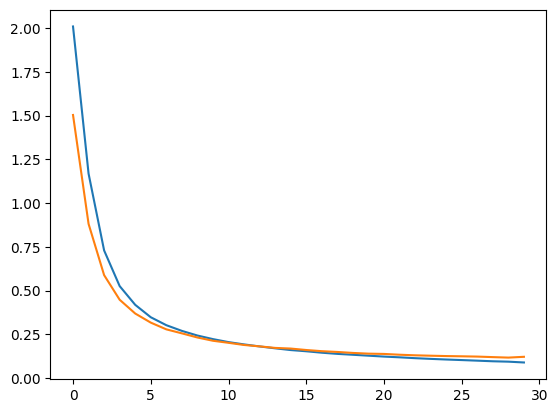

In [74]:
plt.plot(train_losses)
plt.plot(val_losses)

## 回帰NNのbackpropagation

In [95]:
y_train_reg = torch.argmax(y_train, dim=-1)

def mse(X, y):
    return (X[:, 0] - y).pow(2).mean()

def forward_and_backward(X, y):
    # forward
    Z1 = linear(X, W1, b1)
    Z1.retain_grad()
    A1 = relu(Z1)
    A1.retain_grad()
    Z2 = linear(A1, W2, b2)
    Z2.retain_grad()
    # loss, A2 = softmax_cross_entropy(Z2, y) # -> MSE
    loss = mse(Z2, y)

    # backward
    # Z2.grad_ = (A2 - y) / X.shape[0] # -> MSE
    Z2.grad_ = 2 * (Z2 - y.unsqueeze(dim=-1)) / X.shape[0]
    linear_backward(A1, W2, b2, Z2)
    relu_backward(Z1, A1)
    linear_backward(X, W1, b1, Z1)
    return loss, Z1, A1, Z2, A2
    
# パラメータの初期化
m, n = X_train.shape
nh = 30
# パラメータの初期化
W1 = torch.randn((nh, n), requires_grad=True) # 出力 x 入力
b1 = torch.zeros((1, nh), requires_grad=True) # 1 x nh

W2 = torch.randn((1, nh), requires_grad=True) # 出力 x 入力
b2 = torch.zeros((1, 1), requires_grad=True) # 1 x 1
loss, Z1, A1, Z2, A2 = forward_and_backward(X_train, y_train_reg)
loss.backward()

# autogradと等しいことを確認
print(torch.allclose(W1.grad_, W1.grad))
print(torch.allclose(b1.grad_, b1.grad))
print(torch.allclose(W2.grad_, W2.grad))
print(torch.allclose(b2.grad_, b2.grad))

True
True
True
True


## Refactoring

In [103]:
# ======モデル======
class Linear():
    def __init__(self, in_features, out_features):
        self.W = torch.randn((out_features, in_features)) * torch.sqrt(torch.tensor(2.0 / in_features))
        self.W.requires_grad = True
        self.b = torch.zeros((1, out_features), requires_grad=True)
        
    def forward(self, X):
        self.X = X
        self.Z = X @ self.W.T + self.b
        return self.Z

    def backward(self, Z):
        self.W.grad_ = Z.grad_.T @ self.X
        self.b.grad_ = torch.sum(Z.grad_, dim=0)
        self.X.grad_ = Z.grad_ @ self.W
        return self.X.grad_

class ReLU():
    def forward(self, X):
        self.X = X
        return X.clamp_min(0.)

    def backward(self, A):
        return A.grad_ * (self.X > 0).float()

class SoftmaxCrossEntropy:
    def forward(self, X, y):
        e_x = torch.exp(X - torch.max(X, dim=-1, keepdim=True)[0])
        self.softmax_out = e_x / (torch.sum(e_x, dim=-1, keepdim=True) + 1e-10)    
        
        log_probs = torch.log(self.softmax_out + 1e-10)
        target_log_probs = log_probs * y

        self.loss = -target_log_probs.sum(dim=-1).mean()
        return self.loss

    def backward(self, y):
        return (self.softmax_out - y) / y.shape[0]

class Model:
    def __init__(self, input_features, hidden_units, output_units):
        self.linear1 = Linear(input_features, hidden_units)
        self.relu = ReLU()
        self.linear2 = Linear(hidden_units, output_units)
        self.loss_fn = SoftmaxCrossEntropy()
        
    def forward(self, X, y):
        self.X = X
        self.Z1 = self.linear1.forward(X)
        self.A1 = self.relu.forward(self.Z1)
        self.Z2 = self.linear2.forward(self.A1)
        self.loss = self.loss_fn.forward(self.Z2, y)
        return self.loss, self.Z2
    
    def backward(self, y):
        self.Z2.grad_ = self.loss_fn.backward(y)
        self.A1.grad_ = self.linear2.backward(self.Z2)
        self.Z1.grad_ = self.relu.backward(self.A1)
        self.X.grad_ = self.linear1.backward(self.Z1)

    def zero_grad(self):
        # 勾配の初期化
        self.linear1.W.grad_ = None
        self.linear1.b.grad_ = None
        self.linear2.W.grad_ = None
        self.linear2.b.grad_ = None
        
    def step(self, learning_rate):
        # パラメータの更新
        self.linear1.W -= learning_rate * self.linear1.W.grad_
        self.linear1.b -= learning_rate * self.linear1.b.grad_
        self.linear2.W -= learning_rate * self.linear2.W.grad_
        self.linear2.b -= learning_rate * self.linear2.b.grad_

## Refactoring後の学習ループ(OptimizerやDataset, Dataloaderは後ほどRefactoring)
# ===データの準備====
dataset = datasets.load_digits()
data = dataset['data']
target = dataset['target']
images = dataset['images']
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)
X_train = (X_train - X_train.mean()) / X_train.std()
X_val = (X_val - X_train.mean()) / X_train.std()
X_train = torch.tensor(X_train.reshape(-1, 64), dtype=torch.float32)
X_val = torch.tensor(X_val.reshape(-1, 64), dtype=torch.float32)
y_train = F.one_hot(torch.tensor(y_train), num_classes=10) #1437 x 10 
y_val = F.one_hot(torch.tensor(y_val), num_classes=10) # 360 x 10
batch_size = 30
# モデルの初期化
model = Model(input_features=64, hidden_units=10, output_units=10)

learning_rate = 0.01

# ログ
train_losses = []
val_losses = []
val_accuracies = []
for epoch in range(100):
    # エポック毎にデータをシャッフル
    shuffled_indices = np.random.permutation(len(y_train))
    num_batches = np.ceil(len(y_train)/batch_size).astype(int)
    running_loss = 0.0
    
    for i in range(num_batches):
        
        # mini batch作成
        start = i * batch_size
        end = start + batch_size

        batch_indices = shuffled_indices[start:end]
        y_true_ = y_train[batch_indices, :] # batch_size x 10
        
        X = X_train[batch_indices] # batch_size x 64
        # 順伝播と逆伝播の計算
        loss, _ = model.forward(X, y_true_)
        model.backward(y_true_)
        running_loss += loss.item()

        # パラメータ更新
        with torch.no_grad():
            model.step(learning_rate)

        model.zero_grad()

    # validation
    with torch.no_grad():
        val_loss, Z2_val = model.forward(X_val, y_val)
        
        val_accuracy = torch.sum(torch.argmax(Z2_val, dim=-1) == torch.argmax(y_val, dim=-1)) / y_val.shape[0]

    train_losses.append(running_loss/num_batches)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)
    print(f'epoch: {epoch}: train error: {running_loss/num_batches}, validation error: {val_loss.item()}, validation accuracy: {val_accuracy}')

epoch: 0: train error: 2.2523440470298133, validation error: 5.471328258514404, validation accuracy: 0.19722221791744232
epoch: 1: train error: 1.9940015872319539, validation error: 4.700458526611328, validation accuracy: 0.2638888955116272
epoch: 2: train error: 1.8018871371944745, validation error: 4.19155216217041, validation accuracy: 0.3222222328186035
epoch: 3: train error: 1.6201553990443547, validation error: 3.888812303543091, validation accuracy: 0.38055557012557983
epoch: 4: train error: 1.4540905207395554, validation error: 3.594496250152588, validation accuracy: 0.42500001192092896
epoch: 5: train error: 1.2993688136339188, validation error: 3.2498958110809326, validation accuracy: 0.4833333194255829
epoch: 6: train error: 1.1563137955963612, validation error: 3.0558485984802246, validation accuracy: 0.5138888955116272
epoch: 7: train error: 1.0330120126406352, validation error: 2.7142179012298584, validation accuracy: 0.5583333373069763
epoch: 8: train error: 0.9300419315

/tmp/ipykernel_80/782425250.py:30: UserWarning: Deallocating Tensor that still has live PyObject references.  This probably happened because you took out a weak reference to Tensor and didn't call _fix_weakref() after dereferencing it.  Subsequent accesses to this tensor via the PyObject will now fail. (Triggered internally at ../torch/csrc/PyInterpreter.cpp:221.)
  self.softmax_out = e_x / (torch.sum(e_x, dim=-1, keepdim=True) + 1e-10)


epoch: 30: train error: 0.2877894506479303, validation error: 1.1787556409835815, validation accuracy: 0.8305555582046509
epoch: 31: train error: 0.27968938120951253, validation error: 1.1273820400238037, validation accuracy: 0.8388888835906982
epoch: 32: train error: 0.27223343883330625, validation error: 1.1097760200500488, validation accuracy: 0.8444444537162781
epoch: 33: train error: 0.26503761718049645, validation error: 1.1313735246658325, validation accuracy: 0.8444444537162781
epoch: 34: train error: 0.2584956279024482, validation error: 1.1349374055862427, validation accuracy: 0.8527777791023254
epoch: 35: train error: 0.2519673729936282, validation error: 1.0729708671569824, validation accuracy: 0.855555534362793
epoch: 36: train error: 0.24622638849541545, validation error: 1.0988783836364746, validation accuracy: 0.8527777791023254
epoch: 37: train error: 0.24063376849517226, validation error: 1.157753825187683, validation accuracy: 0.8527777791023254
epoch: 38: train erro